In [2]:
!pip install h5py

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/skylake_avx512/software/Python/3.10.4-GCCcore-11.3.0/bin/python -m pip install --upgrade pip' command.


In [3]:
# import NN necessities:
import torch
from torch import nn

# import plotting utilities:
import matplotlib.pyplot as plt

# import data preprocessing utilities:
from sklearn.model_selection import train_test_split
from pathlib import Path
import h5py
import numpy as np

In [23]:
class Network(nn.Module):   # class defining a basic nn

    def __init__(self, h_size=200):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(23, h_size),      # in
            nn.ReLU(),
            nn.Linear(h_size, h_size),    # hidden, 3 layers
            nn.ReLU(),
            nn.Linear(h_size, h_size),
            nn.ReLU(),
            nn.Linear(h_size, h_size),
            nn.ReLU(),
            # nn.Linear(h_size, 18)       # out
        )
        self.mean_head = nn.Linear(h_size, 18)
        self.logvar_head = nn.Linear(h_size, 18)

        # bind log-variance to avoid numerical instability
        self.max_logvar = nn.Parameter(torch.ones(18) * 0.5)
        self.min_logvar = nn.Parameter(torch.ones(18) * -10)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()    # using mean squared error as a loss metric

    def forward(self, x):
        res = self.model(x)
        mean = self.mean_head(res)
        logvar = self.logvar_head(res)

        # clamp log-variance using soft constraints (see MBPO/PETS)
        logvar = self.max_logvar - torch.nn.functional.softplus(self.max_logvar - logvar)
        logvar = self.min_logvar + torch.nn.functional.softplus(logvar - self.min_logvar)
        return mean, logvar

    def nll_loss(self, x, y):
        """
        Negative log-likelihood of Gaussian:
            NLL = 0.5 * [ logσ² + (y - µ)² / σ² ]
        """
        mean, logvar = self.forward(x)
        var = torch.exp(logvar)

        nll = 0.5 * ((y - mean)**2 / var + logvar)
        return nll.mean()

    def train_epoch(self, x, y):
        self.optimizer.zero_grad()

        loss = self.nll_loss(x, y)

        loss.backward()
        self.optimizer.step()
        return loss.item()


    def train(self, train_data, epochs=500, cp=100):
        x, y = train_data

        # again split the data to optimize hyperparam on val set, not leak data.
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True)
    
        test_losses = []
        losses = []
    
        for iter in range(epochs):
            # train
            iteration_loss = self.train_epoch(x_train, y_train)
            losses.append(iteration_loss)

            # validate
            val_loss = self.validation_loss((x_val, y_val))
            test_losses.append(val_loss)
    
            # print
            if iter and iter % cp == 0:    # update on iteration checkpoints
                print(f"iteration {iter}/{epochs}, loss = {iteration_loss}, {val_loss}")
        
        return losses, test_losses


    def validation_loss(self, test_data):
        x, y = test_data
        loss = self.nll_loss(x, y)
        return loss.item()


    def reset(self):
        self.__init__()

In [24]:
# load data
data = h5py.File(Path("./halfcheetah_medium-v2.hdf5"))
print(data.keys())


<KeysViewHDF5 ['actions', 'infos', 'metadata', 'next_observations', 'observations', 'rewards', 'terminals', 'timeouts']>


In [25]:
# extract relevant cols
a = data["actions"]
s_new = data["next_observations"]
s = data["observations"]
r = data["rewards"]

# info
print(
    f"a shape = {a.shape}\n" \
    f"s shape = {s.shape}\n" \
    f"s_new shape = {s_new.shape}\n" \
    f"r shape = {r.shape}\n"
)

a shape = (1000000, 6)
s shape = (1000000, 17)
s_new shape = (1000000, 17)
r shape = (1000000,)



In [26]:
# divide data
x = np.hstack([a, s])                                # -> (N, 23)
y = np.hstack([s_new, np.array(r).reshape(-1, 1)])   # -> (N, 18)

# converting to tensors
x = torch.tensor(x, dtype=torch.float32)   
y = torch.tensor(y, dtype=torch.float32)


In [27]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# your Network class exactly as you gave it above ...
# (no need to change it)

def validation_mse(model: Network, x_val: torch.Tensor, y_val: torch.Tensor, device) -> float:
    """Compute MSE on validation set using the mean head of the model."""
    with torch.no_grad():
        mean, _ = model.forward(x_val.to(device))
        mse = nn.MSELoss()(mean.to(device), y_val.to(device))
    return mse.item()

In [28]:
def run_size_sweep(x: torch.Tensor, y: torch.Tensor,
                   max_epochs: int = 100,
                   n_sizes: int = 20):
    """
    Train networks with different hidden sizes and record validation MSE curves.

    Returns
    -------
    hidden_sizes : list[int]
    val_mse_curves : np.ndarray of shape (n_sizes, max_epochs)
    """
    # split once so all models see the same train/val split
    x_train, x_val, y_train, y_val = train_test_split(
        x, y, test_size=0.2, shuffle=True
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"using device: {device}")
    
    x_train = x_train.to(device)
    x_test = x_val.to(device)
    y_train = y_train.to(device)
    y_test = y_val.to(device)

    # choose 20 hidden sizes, e.g. from 20 to 400
    hidden_sizes = np.linspace(20, 150, n_sizes, dtype=int)

    val_mse_curves = np.zeros((n_sizes, max_epochs))
    

    for i, h_size in enumerate(hidden_sizes):
        print(f"\n=== Training model with h_size = {h_size} ===")
        arr = [-1,-1,-1]
        for j in range(3):
            net = Network(h_size=h_size)
            net = net.to(device)

            net.train((x_train,y_train), epochs=max_epochs, cp=20)

                # compute validation MSE
            mse_val = validation_mse(net, x_val, y_val, device)
            arr[j] = mse_val
            
        val_mse_curves[i, max_epochs-1] = sum(arr)/3

    return hidden_sizes, val_mse_curves


In [29]:
hidden_sizes, val_mse_curves = run_size_sweep(x, y, max_epochs=5000, n_sizes=1)

final_mse = val_mse_curves[:, -1]  # MSE after last epoch



using device: cuda

=== Training model with h_size = 20 ===
iteration 20/5000, loss = 15.163732528686523, 15.124886512756348
iteration 40/5000, loss = 13.878435134887695, 13.80697250366211
iteration 60/5000, loss = 11.722997665405273, 11.611547470092773
iteration 80/5000, loss = 9.709266662597656, 9.652114868164062
iteration 100/5000, loss = 8.958100318908691, 8.949578285217285
iteration 120/5000, loss = 8.763777732849121, 8.764944076538086
iteration 140/5000, loss = 8.567866325378418, 8.569952964782715
iteration 160/5000, loss = 8.468700408935547, 8.471020698547363
iteration 180/5000, loss = 8.372944831848145, 8.375967979431152
iteration 200/5000, loss = 8.283133506774902, 8.28659725189209
iteration 220/5000, loss = 8.202117919921875, 8.206003189086914
iteration 240/5000, loss = 8.134517669677734, 8.139158248901367
iteration 260/5000, loss = 8.080137252807617, 8.085368156433105
iteration 280/5000, loss = 8.033408164978027, 8.038864135742188
iteration 300/5000, loss = 7.991274356842041

KeyboardInterrupt: 

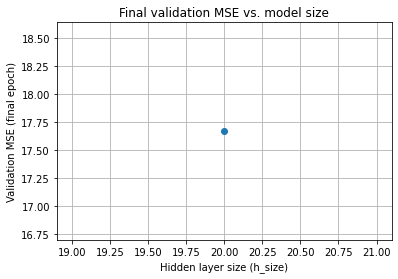

In [11]:
plt.figure()
plt.plot(hidden_sizes, final_mse, marker="o")
plt.xlabel("Hidden layer size (h_size)")
plt.ylabel("Validation MSE (final epoch)")
plt.title("Final validation MSE vs. model size")
plt.grid(True)
plt.show()

In [12]:
OUTDIR = Path(".")          # current directory = Mopo_test
OUTDIR.mkdir(exist_ok=True)

plt.savefig(OUTDIR / "loss_curve.png", dpi=200)
plt.close()

In [32]:
# set device
x = np.hstack([a, s])                                # -> (N, 23)
y = np.hstack([s_new, np.array(r).reshape(-1, 1)])   # -> (N, 18)

# converting to tensors
x = torch.tensor(x, dtype=torch.float32)   
y = torch.tensor(y, dtype=torch.float32)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True
)

# info
print(
    f"x_train shape = {x_train.shape}\n" \
    f"x_test shape = {x_test.shape}\n" \
    f"y_train shape = {y_train.shape}\n" \
    f"y_test shape = {y_test.shape}"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# set_data
train_data = (x_train, y_train)
test_data = (x_test, y_test)

# set params
epochs = 10000

# for network_width in width_list:
model = Network( h_size=50 )
model = model.to(device)

# train
train_losses, test_losses = model.train(train_data, epochs=epochs, cp=10)
# test_results.append(test_losses)

x_train shape = torch.Size([800000, 23])
x_test shape = torch.Size([200000, 23])
y_train shape = torch.Size([800000, 18])
y_test shape = torch.Size([200000, 18])
using device: cuda
iteration 10/10000, loss = 15.24105453491211, 15.027470588684082
iteration 20/10000, loss = 12.67645263671875, 12.392057418823242
iteration 30/10000, loss = 10.263128280639648, 10.097777366638184
iteration 40/10000, loss = 9.457069396972656, 9.406291961669922
iteration 50/10000, loss = 8.951292037963867, 8.916265487670898
iteration 60/10000, loss = 8.654077529907227, 8.619485855102539
iteration 70/10000, loss = 8.349952697753906, 8.321093559265137
iteration 80/10000, loss = 8.068102836608887, 8.037579536437988
iteration 90/10000, loss = 7.769552707672119, 7.736114501953125
iteration 100/10000, loss = 7.438640594482422, 7.400972843170166
iteration 110/10000, loss = 7.095208644866943, 7.060754776000977
iteration 120/10000, loss = 6.812288761138916, 6.783164024353027
iteration 130/10000, loss = 6.55271100997924

iteration 1240/10000, loss = 3.402620792388916, 3.399160861968994
iteration 1250/10000, loss = 3.395944595336914, 3.391622304916382
iteration 1260/10000, loss = 3.39245343208313, 3.392141103744507
iteration 1270/10000, loss = 3.3952674865722656, 3.380378484725952
iteration 1280/10000, loss = 3.380678176879883, 3.3726770877838135
iteration 1290/10000, loss = 3.368889570236206, 3.3661961555480957
iteration 1300/10000, loss = 3.3791661262512207, 3.39695143699646
iteration 1310/10000, loss = 3.3666131496429443, 3.3710381984710693
iteration 1320/10000, loss = 3.353760004043579, 3.3513145446777344
iteration 1330/10000, loss = 3.347468376159668, 3.3418772220611572
iteration 1340/10000, loss = 3.347917079925537, 3.3507721424102783
iteration 1350/10000, loss = 3.342885732650757, 3.348477363586426
iteration 1360/10000, loss = 3.3311729431152344, 3.334256172180176
iteration 1370/10000, loss = 3.3300819396972656, 3.324204921722412
iteration 1380/10000, loss = 3.3217601776123047, 3.318300485610962


iteration 2470/10000, loss = 3.084298610687256, 3.0734264850616455
iteration 2480/10000, loss = 3.04911208152771, 3.0456550121307373
iteration 2490/10000, loss = 3.047267436981201, 3.042048692703247
iteration 2500/10000, loss = 3.056880474090576, 3.0420684814453125
iteration 2510/10000, loss = 3.043489694595337, 3.0378851890563965
iteration 2520/10000, loss = 3.0536742210388184, 3.0377376079559326
iteration 2530/10000, loss = 3.068567991256714, 3.0540549755096436
iteration 2540/10000, loss = 3.0473673343658447, 3.0397439002990723
iteration 2550/10000, loss = 3.062544584274292, 3.063999652862549
iteration 2560/10000, loss = 3.053281307220459, 3.0381457805633545
iteration 2570/10000, loss = 3.0367493629455566, 3.03078556060791
iteration 2580/10000, loss = 3.0484659671783447, 3.0399434566497803
iteration 2590/10000, loss = 3.033933401107788, 3.0237624645233154
iteration 2600/10000, loss = 3.051676034927368, 3.0508480072021484
iteration 2610/10000, loss = 3.0345041751861572, 3.021100997924

iteration 3700/10000, loss = 2.894322156906128, 2.892582416534424
iteration 3710/10000, loss = 2.9006197452545166, 2.8936092853546143
iteration 3720/10000, loss = 2.900926351547241, 2.9022445678710938
iteration 3730/10000, loss = 2.898165464401245, 2.8849263191223145
iteration 3740/10000, loss = 2.9016671180725098, 2.9129858016967773
iteration 3750/10000, loss = 2.913806200027466, 2.8934459686279297
iteration 3760/10000, loss = 2.929326057434082, 2.927421808242798
iteration 3770/10000, loss = 2.8937811851501465, 2.886770486831665
iteration 3780/10000, loss = 2.884408712387085, 2.8755316734313965
iteration 3790/10000, loss = 2.9246528148651123, 2.9279625415802
iteration 3800/10000, loss = 2.893381357192993, 2.8773000240325928
iteration 3810/10000, loss = 2.88778018951416, 2.8809561729431152
iteration 3820/10000, loss = 2.9194700717926025, 2.89646053314209
iteration 3830/10000, loss = 2.8952083587646484, 2.8820555210113525
iteration 3840/10000, loss = 2.8839612007141113, 2.88383221626281

iteration 4930/10000, loss = 2.8135740756988525, 2.8164639472961426
iteration 4940/10000, loss = 2.7993807792663574, 2.7880163192749023
iteration 4950/10000, loss = 2.7910537719726562, 2.7888553142547607
iteration 4960/10000, loss = 2.8509469032287598, 2.8539767265319824
iteration 4970/10000, loss = 2.814251184463501, 2.7973804473876953
iteration 4980/10000, loss = 2.7970104217529297, 2.790968179702759
iteration 4990/10000, loss = 2.8003392219543457, 2.7953643798828125
iteration 5000/10000, loss = 2.7866992950439453, 2.786165237426758
iteration 5010/10000, loss = 2.806575298309326, 2.809156656265259
iteration 5020/10000, loss = 2.8226723670959473, 2.7860705852508545
iteration 5030/10000, loss = 2.7865118980407715, 2.7844865322113037
iteration 5040/10000, loss = 2.793508291244507, 2.785229444503784
iteration 5050/10000, loss = 2.8096652030944824, 2.8308372497558594
iteration 5060/10000, loss = 2.795231342315674, 2.7991573810577393
iteration 5070/10000, loss = 2.786787271499634, 2.776190

iteration 6160/10000, loss = 2.7130556106567383, 2.7102890014648438
iteration 6170/10000, loss = 2.859894037246704, 2.746770143508911
iteration 6180/10000, loss = 2.7506139278411865, 2.7360029220581055
iteration 6190/10000, loss = 2.726123571395874, 2.718583822250366
iteration 6200/10000, loss = 2.731329917907715, 2.729346990585327
iteration 6210/10000, loss = 2.7193105220794678, 2.712287187576294
iteration 6220/10000, loss = 2.713134765625, 2.7096431255340576
iteration 6230/10000, loss = 2.7320141792297363, 2.7182681560516357
iteration 6240/10000, loss = 2.707990884780884, 2.701953411102295
iteration 6250/10000, loss = 2.7214181423187256, 2.7183637619018555
iteration 6260/10000, loss = 2.7716898918151855, 2.7521705627441406
iteration 6270/10000, loss = 2.742169141769409, 2.723719358444214
iteration 6280/10000, loss = 2.717039108276367, 2.718897819519043
iteration 6290/10000, loss = 2.7141644954681396, 2.7196574211120605
iteration 6300/10000, loss = 2.7151076793670654, 2.70405602455139

iteration 7390/10000, loss = 2.6629254817962646, 2.6527881622314453
iteration 7400/10000, loss = 2.6567647457122803, 2.6582369804382324
iteration 7410/10000, loss = 2.7766804695129395, 2.8295135498046875
iteration 7420/10000, loss = 2.700693130493164, 2.705155611038208
iteration 7430/10000, loss = 2.6806247234344482, 2.6516330242156982
iteration 7440/10000, loss = 2.666224241256714, 2.650665760040283
iteration 7450/10000, loss = 2.6539294719696045, 2.651287078857422
iteration 7460/10000, loss = 2.666370153427124, 2.663177013397217
iteration 7470/10000, loss = 2.654097318649292, 2.6487765312194824
iteration 7480/10000, loss = 2.667132616043091, 2.6637001037597656
iteration 7490/10000, loss = 2.653175115585327, 2.651279926300049
iteration 7500/10000, loss = 2.6579556465148926, 2.6582047939300537
iteration 7510/10000, loss = 2.7300851345062256, 2.7266273498535156
iteration 7520/10000, loss = 2.6777002811431885, 2.6543235778808594
iteration 7530/10000, loss = 2.661255121231079, 2.652024030

iteration 8620/10000, loss = 2.6111104488372803, 2.615143060684204
iteration 8630/10000, loss = 2.610278844833374, 2.6001882553100586
iteration 8640/10000, loss = 2.6120357513427734, 2.6102631092071533
iteration 8650/10000, loss = 2.6020348072052, 2.5985934734344482
iteration 8660/10000, loss = 2.604703903198242, 2.6006717681884766
iteration 8670/10000, loss = 2.615433931350708, 2.6093599796295166
iteration 8680/10000, loss = 2.624204158782959, 2.6415576934814453
iteration 8690/10000, loss = 2.609431028366089, 2.639204502105713
iteration 8700/10000, loss = 2.6021931171417236, 2.602445602416992
iteration 8710/10000, loss = 2.612290859222412, 2.62268328666687
iteration 8720/10000, loss = 2.6293842792510986, 2.6763267517089844
iteration 8730/10000, loss = 2.6197664737701416, 2.6119701862335205
iteration 8740/10000, loss = 2.6062097549438477, 2.597557783126831
iteration 8750/10000, loss = 2.5995965003967285, 2.5960075855255127
iteration 8760/10000, loss = 2.621101140975952, 2.6281466484069

iteration 9850/10000, loss = 2.5675530433654785, 2.5936074256896973
iteration 9860/10000, loss = 2.5674784183502197, 2.5545620918273926
iteration 9870/10000, loss = 2.5587048530578613, 2.5544183254241943
iteration 9880/10000, loss = 2.577502965927124, 2.585887908935547
iteration 9890/10000, loss = 2.578519582748413, 2.5778770446777344
iteration 9900/10000, loss = 2.557889699935913, 2.5618977546691895
iteration 9910/10000, loss = 2.5598435401916504, 2.551727771759033
iteration 9920/10000, loss = 2.5581538677215576, 2.553149700164795
iteration 9930/10000, loss = 2.646206855773926, 2.631617546081543
iteration 9940/10000, loss = 2.6009984016418457, 2.5705387592315674
iteration 9950/10000, loss = 2.569537401199341, 2.5612640380859375
iteration 9960/10000, loss = 2.562255620956421, 2.5597047805786133
iteration 9970/10000, loss = 2.556330680847168, 2.553394079208374
iteration 9980/10000, loss = 2.5863230228424072, 2.590932846069336
iteration 9990/10000, loss = 2.5736472606658936, 2.5710339546

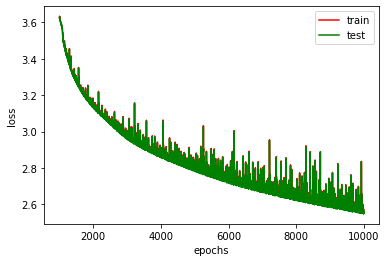

In [33]:
# plot data
fig, ax = plt.subplots(1, 1)
x = np.arange(1000, epochs)
ax.plot(x, train_losses[1000:], label='train', color='red')
ax.plot(x, test_losses[1000:], label='test', color='green')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.legend()
plt.show()